In [ ]:
#wuhuu 1.93 kaldi 0.30 gelistirme
#yapilacaklardan bazilari -- lat lon verilerini en yakin bes sehiri isaretleme
#lag olarak son dort gunun verilerini girme (elektrik aletlerin de bi direnme durumu var eger hava 4 gun ust uste cok sogursa bunu model bilmeli)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer


def aggregate_weather_data(daily_weather):
    # Convert 'tarih' column to datetime format
    daily_weather['tarih'] = pd.to_datetime(daily_weather['tarih'])
    
    # Extract day and hour from 'tarih'
    daily_weather['day'] = daily_weather['tarih'].dt.date
    daily_weather['hour'] = daily_weather['tarih'].dt.hour

    # Group the data by 'ilce' and date
    daily_weather = daily_weather.groupby(['ilce', pd.Grouper(freq='D', key='tarih')])
    
    # Aggregate weather data by group
    daily_weather = daily_weather.agg({
        't_2m:C': ['max', 'min', 'mean', 'std'],  # temperature
        'prob_precip_1h:p': ['sum', 'max', 'mean'],  # precipitation
        'wind_speed_10m:ms': ['max', 'mean', 'std'],  # wind speed
        'wind_dir_10m:d': 'mean',  # wind direction
        'global_rad:W': 'sum',  # sunshine duration
        'effective_cloud_cover:p': ['mean', 'std'],  # cloud cover
        'relative_humidity_2m:p': ['max', 'min', 'mean']  # humidity
    })

    # Flatten the MultiIndex columns
    daily_weather.columns = ['_'.join(col).strip() for col in daily_weather.columns.values]
    
    # Reset the index
    daily_weather = daily_weather.reset_index()
    DCOLUMN =  daily_weather.columns


    l = [1,2,3]
    for i in l:
        for col in DCOLUMN:
            if col not in ['ilce', 'tarih']:
                daily_weather[f'{col}_lag{i}'] = daily_weather.groupby('ilce')[col].shift(i)
    imputer = SimpleImputer(strategy='mean')  # or 'median' for median imputation

    # Impute missing values in the lagged feature columns
    for col in [col for col in daily_weather.columns if col.endswith('_lag')]:
        imputer.fit(daily_weather[col].values.reshape(-1, 1))
        daily_weather[col] = imputer.transform(daily_weather[col].values.reshape(-1, 1))
        # Define a growth rate function
    def growth_rate(temp, solar_rad):
        return 0.01 * temp * solar_rad

    # Initialize a column for cumulative growth
    daily_weather['cumulative_growth'] = 0

    # Iterate over the rows and calculate cumulative growth
    for i, row in daily_weather.iterrows():
        temp = row['t_2m:C_mean']
        solar_rad = row['global_rad:W_sum']

        # Calculate growth rate for the current day
        daily_growth = growth_rate(temp, solar_rad)

        # Update cumulative growth
        if row['tarih'].month >= 10 or row['tarih'].month <= 2:  # Assume no growth during fall and winter
            daily_growth = 0
        elif row['t_2m:C_max'] < 5:  # Assume no growth below 5°C
            daily_growth = 0

        daily_weather.at[i, 'cumulative_growth'] += daily_growth

    # Normalize cumulative growth to a range of 0 to 1
    daily_weather['cumulative_growth'] = (daily_weather['cumulative_growth'] - daily_weather['cumulative_growth'].min()) / (daily_weather['cumulative_growth'].max() - daily_weather['cumulative_growth'].min())

    # Add column for trees waking up
#    daily_weather['trees_waking_up'] = (
        #(daily_weather['tarih'].dt.month >= 3) &
        #(daily_weather['tarih'].dt.month <= 5) &
        #(daily_weather['t_2m:C_mean'] > 10) &
        #(daily_weather['global_rad:W_sum'] > 200)
    #).astype(int)

    ## Add column for animals emerging from hibernation
    #daily_weather['animals_emerging'] = (
        #(daily_weather['tarih'].dt.month >= 3) &
        #(daily_weather['tarih'].dt.month <= 5) &
        #(daily_weather['t_2m:C_mean'] > 5) &
        #(daily_weather['prob_precip_1h:p_sum'] > 0.2)
    #).astype(int)

    # Add column for thunderstorm probability
    def thunderstorm_probability(row):
        temp = row['t_2m:C_max']
        precip_prob = row['prob_precip_1h:p_max']
        wind_speed = row['wind_speed_10m:ms_max']
        cloud_cover = row['effective_cloud_cover:p_mean']

        # Conditions for thunderstorm probability
        if temp > 25 and precip_prob > 0.5 and wind_speed > 10 and cloud_cover > 0.6:
            return 0.8  # High probability (80%)
        elif temp > 20 and precip_prob > 0.3 and wind_speed > 5 and cloud_cover > 0.4:
            return 0.5  # Moderate probability (50%)
        else:
            return 0.2  # Low probability (20%)

    daily_weather['thunderstorm_probability'] = daily_weather.apply(thunderstorm_probability, axis=1)

  

    # Plot the cumulative growth
    plt.figure(figsize=(12, 6))
    plt.plot(daily_weather['tarih'], daily_weather['cumulative_growth'])
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Cumulative Growth', fontsize=14)
    plt.title('Tree Growth over Time', fontsize=16)
    plt.xticks(rotation=45)
    plt.show()

    ## Plot trees waking up
    #plt.figure(figsize=(12, 6))
    #plt.plot(daily_weather['tarih'], daily_weather['trees_waking_up'])
    #plt.xlabel('Date', fontsize=14)
    #plt.ylabel('Trees Waking Up', fontsize=14)
    #plt.title('Trees Waking Up over Time', fontsize=16)
    #plt.xticks(rotation=45)
    #plt.show()

    ## Plot animals emerging from hibernation
    #plt.figure(figsize=(12, 6))
    #plt.plot(daily_weather['tarih'], daily_weather['animals_emerging'])
    #plt.xlabel('Date', fontsize=14)
    #plt.ylabel('Animals Emerging', fontsize=14)
    #plt.title('Animals Emerging from Hibernation over Time', fontsize=16)
    #plt.xticks(rotation=45)
    #plt.show()

    ## Plot thunderstorm probability
    plt.figure(figsize=(12, 6))
    plt.plot(daily_weather['tarih'], daily_weather['thunderstorm_probability'])
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Thunderstorm Probability', fontsize=14)
    plt.title('Thunderstorm Probability over Time', fontsize=16)
    plt.xticks(rotation=45)
    plt.show()

    return daily_weather


def create_unique_id(df):
    df['unique_id'] = df['tarih'].astype(str) +  '-' +df['ilce'].astype(str) 
    return df


In [ ]:
from datetime import datetime
train= pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")
weather = pd.read_csv("weather.csv")
holidays = pd.read_csv("holidays.csv")

# "date" sütununu "tarih" olarak değiştirme
weather.rename(columns={"date": "tarih"}, inplace=True)
weather.rename(columns={"name": "ilce"}, inplace=True)


citylatlong = weather[['ilce', 'lat', 'lon']]
citylatlong

In [ ]:

# Tüm ilçe isimlerini küçük harfe dönüştür
weather["ilce"] = weather["ilce"].str.lower()
train["ilce"] = train["ilce"].str.lower()
test["ilce"] = test["ilce"].str.lower()

print(len(test))
print(len(train))





In [ ]:
weather.rename(columns={'date': 'tarih','name':'ilce'}, inplace=True)
weather = aggregate_weather_data(weather)
#weather = create_unique_id(weather)
#weather['unique_id']

weather

In [ ]:
holidays = pd.read_csv('holidays.csv')
holidays.columns =['year', 'month' ,'day' , 'holiday']
add_columns = holidays['holiday']
# Create a new column for each unique holiday name

holidays['tarih'] = pd.to_datetime(holidays[['year', 'month', 'day']])
for new in holidays['holiday'].unique():
    holidays[new] = (holidays['holiday'] == new).astype(int)
holidays.drop(['holiday', 'year', 'month', 'day'] , axis=1 , inplace=True)
holidays.columns
holidays.tail()


In [ ]:
weather

In [ ]:

after_date = datetime(2024, 2, 1)
# train data buraya baslangictan 2024/2/01'a kadar olacak
weather_train = weather[weather['tarih'] < after_date]
holidays_train = holidays[holidays['tarih'] < after_date]

# test data buraya sadece asagidaki tarihten itibaren olacak
weather_test = weather[weather['tarih'] >= after_date ]
holidays_test = holidays[holidays['tarih'] >= after_date]
len(weather_test)


In [ ]:
#ARADA BOSLUK GUNLER VAR ONLARI MEAN ILE DOLDURDUK SORUN OLABILIR TABI AMA OLSUN
from sklearn.impute import SimpleImputer


columns_to_impute = ['bildirimsiz_sum', 'bildirimli_sum']

# Create a simple imputer
imputer = SimpleImputer(strategy='mean')

# Fit the imputer to the data
imputer.fit(train[columns_to_impute])

# Impute the missing values
train[columns_to_impute] = imputer.transform(train[columns_to_impute])
train.tail()

In [ ]:
train.columns = ['tarih' , 'ilce' , 'bildirimsiz_sum', 'bildirimli_sum']
#train = create_unique_id(train)
train['tarih'] = pd.to_datetime(train['tarih'])
 #Process data and train model
train

In [ ]:
test.columns= ['tarih','ilce','bildirimli_sum']
#test = create_unique_id(test)
test.head()
print(len(test))

In [ ]:

sample_submission.tail()

In [ ]:
train.sample()

In [ ]:
##@@@ test ops train ops
test['tarih'] = pd.to_datetime(test['tarih'])

test['days_in_month'] = test['tarih'].dt.days_in_month
test['days_in_year'] = test['tarih'].dt.day_of_year
test['days_in_week'] = test['tarih'].dt.weekday
test['month'] = test['tarih'].dt.month
test['year'] = test['tarih'].dt.year

train['tarih'] = pd.to_datetime(train['tarih'])

train['days_in_month'] = train['tarih'].dt.days_in_month
train['days_in_year'] = train['tarih'].dt.day_of_year
train['days_in_week'] = train['tarih'].dt.weekday
train['month'] = train['tarih'].dt.month
train['year'] = train['tarih'].dt.year


# Tarih sütunlarının formatlarını uygun hale getir
weather["tarih"] = pd.to_datetime(weather["tarih"])
train["tarih"] = pd.to_datetime(train["tarih"])
test["tarih"] = pd.to_datetime(test["tarih"])
max(test['tarih'])
len(test)

In [ ]:
from sklearn.calibration import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(train['ilce'])
# Transform both datasets using the same encoder
train['ilce-value'] = label_encoder.transform(train['ilce'])
test['ilce-value'] = label_encoder.transform(test['ilce'])
# Create a dictionary to map the encoded values back to the original labels
ilce_value_map = {v: k for k, v in enumerate(label_encoder.classes_)}
print(ilce_value_map)


In [ ]:
# Set ilce and tarih as the index
test.set_index(['ilce', 'tarih'], inplace=True)
weather_test.set_index(['ilce', 'tarih'], inplace=True)
train.set_index(['ilce', 'tarih'], inplace=True)
weather_train.set_index(['ilce', 'tarih'], inplace=True)





In [ ]:

# Merge the dataframes
test_df = pd.merge(test, weather_test, on=['ilce', 'tarih'])
train_df = pd.merge(train, weather_train, on=['ilce', 'tarih'])
train_df.dropna()
test_df.dropna()
# Replace NaN values with 0 in the train dataframe
train_df = train_df.fillna(0)

# Replace NaN values with 0 in the test dataframe
test_df = test_df.fillna(0)
len(test_df)
test_df.columns

Creating Weather data and merging them into train data 

In [ ]:
train_index_values = train_df.index.get_level_values('tarih')
train_df['tarih-value'] = pd.factorize(train_index_values)[0]
max_train_tarih = max(train_df['tarih-value'])

test_index_values = test_df.index.get_level_values('tarih')
test_df['tarih-value'] = pd.factorize(test_index_values)[0] + max_train_tarih + 1

test_df

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

# Hedef değişkeni ve özellikleri ayır
X = train_df.drop(columns=["bildirimsiz_sum"])
print('is it null  :' , X.isnull().sum())  # Print the sum of NaN values for each feature column

y = train_df["bildirimsiz_sum"]

corr = train_df.corr()
target_corr = abs(corr["bildirimsiz_sum"])
corr_threshold = 0.02
high_corr_features = target_corr[target_corr > corr_threshold]
# özellik isimlerini alalım ve bildirimsiz_sum özelliğini çıkaralım
hcf_names = [k for k, v in high_corr_features.items()]; hcf_names.remove("bildirimsiz_sum")
#print(hcf_names)

features=['bildirimli_sum', 'days_in_month', 'days_in_year', 'days_in_week', 'month', 'year', 'ilce-value', 't_2m:C_max', 't_2m:C_min', 't_2m:C_mean', 't_2m:C_std', 'prob_precip_1h:p_sum', 'prob_precip_1h:p_max', 'prob_precip_1h:p_mean', 'wind_speed_10m:ms_max', 'wind_speed_10m:ms_mean', 'wind_speed_10m:ms_std', 'wind_dir_10m:d_mean', 'global_rad:W_sum', 'effective_cloud_cover:p_mean', 'effective_cloud_cover:p_std', 'relative_humidity_2m:p_max', 'relative_humidity_2m:p_min', 'relative_humidity_2m:p_mean', 't_2m:C_max_lag1', 't_2m:C_min_lag1', 't_2m:C_mean_lag1', 't_2m:C_std_lag1', 'prob_precip_1h:p_sum_lag1', 'prob_precip_1h:p_max_lag1', 'prob_precip_1h:p_mean_lag1', 'wind_speed_10m:ms_max_lag1', 'wind_speed_10m:ms_mean_lag1', 'wind_speed_10m:ms_std_lag1', 'wind_dir_10m:d_mean_lag1', 'global_rad:W_sum_lag1', 'effective_cloud_cover:p_mean_lag1', 'effective_cloud_cover:p_std_lag1', 'relative_humidity_2m:p_max_lag1', 'relative_humidity_2m:p_min_lag1', 'relative_humidity_2m:p_mean_lag1', 't_2m:C_max_lag2', 't_2m:C_min_lag2', 't_2m:C_mean_lag2', 't_2m:C_std_lag2', 'prob_precip_1h:p_sum_lag2', 'prob_precip_1h:p_max_lag2', 'prob_precip_1h:p_mean_lag2', 'wind_speed_10m:ms_max_lag2', 'wind_speed_10m:ms_mean_lag2', 'wind_speed_10m:ms_std_lag2', 'wind_dir_10m:d_mean_lag2', 'global_rad:W_sum_lag2', 'effective_cloud_cover:p_mean_lag2', 'effective_cloud_cover:p_std_lag2', 'relative_humidity_2m:p_max_lag2', 'relative_humidity_2m:p_min_lag2', 'relative_humidity_2m:p_mean_lag2', 't_2m:C_max_lag3', 't_2m:C_min_lag3', 't_2m:C_mean_lag3', 't_2m:C_std_lag3', 'prob_precip_1h:p_sum_lag3', 'prob_precip_1h:p_max_lag3', 'prob_precip_1h:p_mean_lag3', 'wind_speed_10m:ms_max_lag3', 'wind_speed_10m:ms_mean_lag3', 'wind_speed_10m:ms_std_lag3', 'wind_dir_10m:d_mean_lag3', 'global_rad:W_sum_lag3', 'effective_cloud_cover:p_mean_lag3', 'effective_cloud_cover:p_std_lag3', 'relative_humidity_2m:p_max_lag3', 'relative_humidity_2m:p_min_lag3', 'relative_humidity_2m:p_mean_lag3', 'cumulative_growth', 'thunderstorm_probability', 'tarih-value']

In [ ]:
print(train_df.columns.tolist())




In [ ]:


X_test = test_df[features]
X_test

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 10],
    'n_estimators': [50, 100, 200],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 1.0],
    'gamma': [0, 0.1, 0.3]
}

# Model oluşturma
xgb = XGBRegressor()

# GridSearchCV ile en iyi parametre kombinasyonunun bulunması
#grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
#grid_search.fit(X,y)
#njobs -1 olmali (benim makinem paralel calismiyor cunku )
# En iyi parametrelerin bulunması
#best_params = grid_search.best_params_

#eski 1.bestparams = learningrate : 0.01 maxdepth 10 yenisi asagida
best_params = {'colsample_bytree': 0.4, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 50, 'subsample': 0.8}
print("En iyi parametreler:", best_params)


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb

# XGBoost model
xgboost_model = xgb.XGBRegressor(colsample_bytree=0.4, gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=50, subsample=0.8)
xgboost_model.fit(train_df[features], y)
print('xgboost model')



In [ ]:

print(train_df[features].isnull().sum())
# Random Forest model
rf_model = RandomForestRegressor(n_estimators=5)
rf_model.fit(train_df[features], y)
print('random forest model')


In [ ]:


catboost_model = CatBoostRegressor()
catboost_model.fit(train_df[features], y)
print('catboost model')



In [ ]:

# Gradient Boosting model
gb_model = GradientBoostingRegressor(learning_rate=0.01, max_depth=10)
gb_model.fit(train_df[features], y)
print('gb model')


In [ ]:
print(len(test_df))

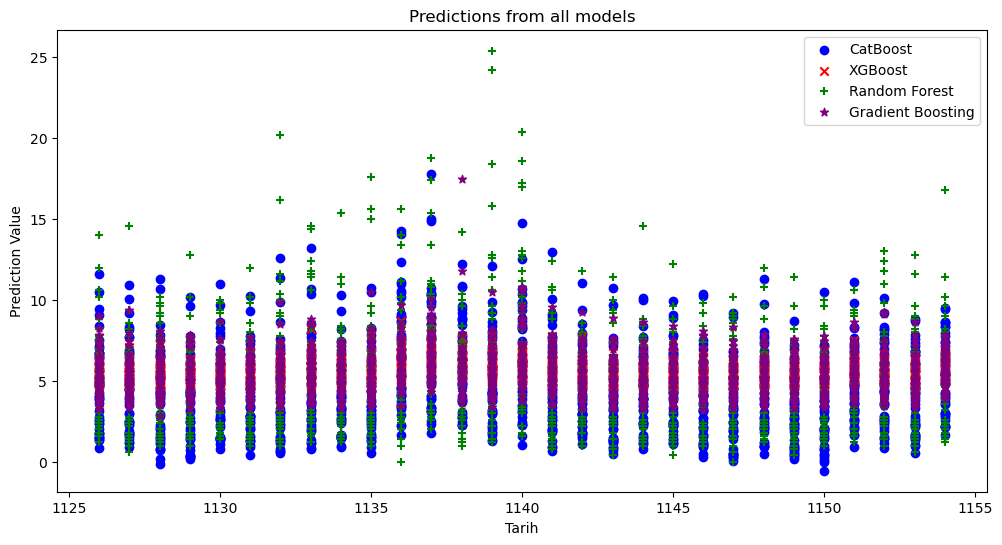

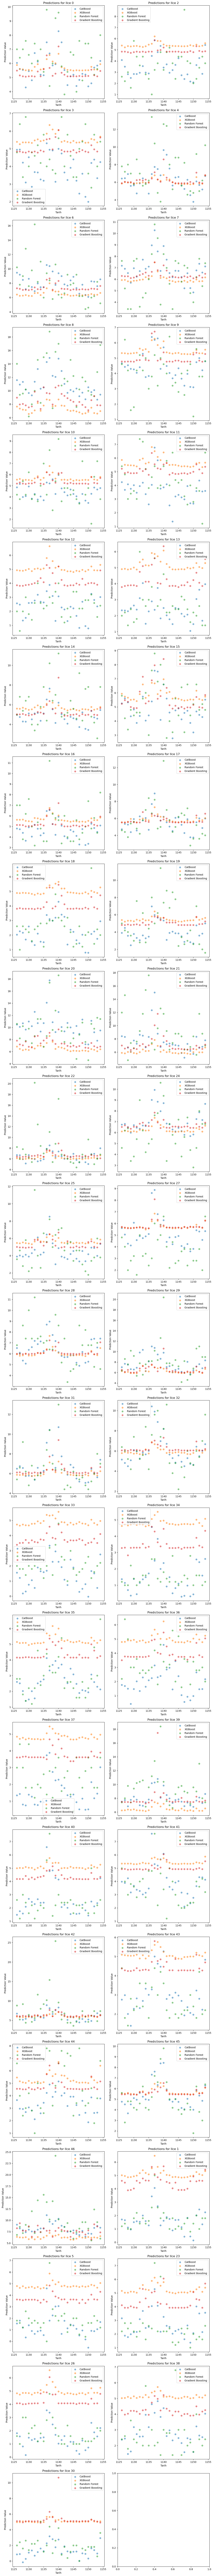

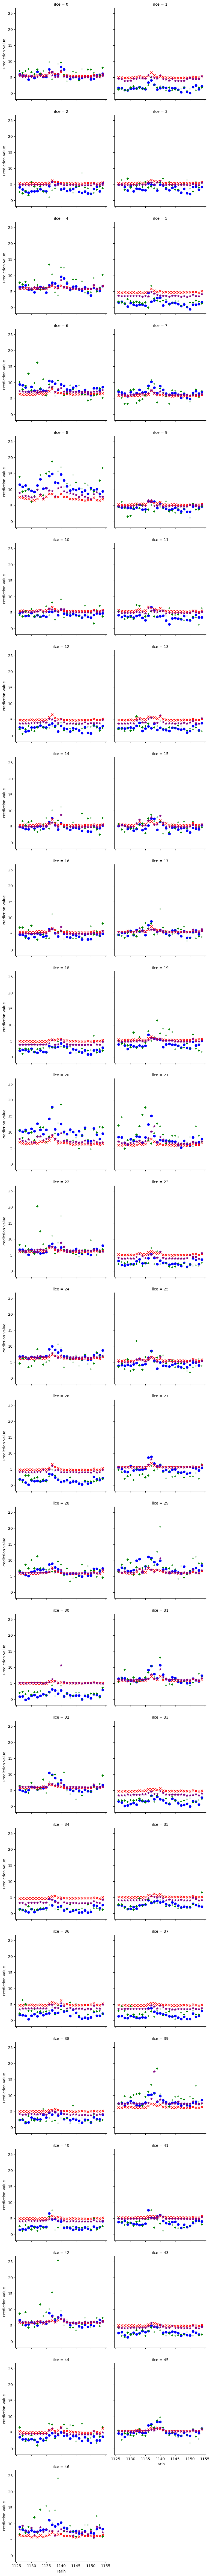

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assume catboost_preds, xgboost_preds, rf_preds, and gb_preds are your predictions
# and X_test is your test data
xgboost_preds = xgboost_model.predict(X_test)
catboost_preds = catboost_model.predict(X_test)
rf_preds = rf_model.predict(X_test)
gb_preds = gb_model.predict(X_test)

# Create a DataFrame to store the predictions
df = pd.DataFrame({'tarih': X_test['tarih-value'],
                   'ilce': X_test['ilce-value'],
                   'CatBoost': catboost_preds,
                   'XGBoost': xgboost_preds,
                   'Random Forest': rf_preds,
                   'Gradient Boosting': gb_preds})

# Plot all models on the same axis with different colors and markers
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(df['tarih'], df['CatBoost'], label='CatBoost', color='blue', marker='o')
ax.scatter(df['tarih'], df['XGBoost'], label='XGBoost', color='red', marker='x')
ax.scatter(df['tarih'], df['Random Forest'], label='Random Forest', color='green', marker='+')
ax.scatter(df['tarih'], df['Gradient Boosting'], label='Gradient Boosting', color='purple', marker='*')
ax.set_title('Predictions from all models')
ax.set_xlabel('Tarih')
ax.set_ylabel('Prediction Value')
ax.legend()

# Plot different models for each 'ilce' value
ilce_values = df['ilce'].unique()
n_cols = 2
n_rows = (len(ilce_values) + n_cols - 1) // n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 6 * n_rows), squeeze=False)

for i, ilce_val in enumerate(ilce_values):
    row, col = divmod(i, n_cols)
    ax = axs[row, col]
    group = df[df['ilce'] == ilce_val]
    for model in ['CatBoost', 'XGBoost', 'Random Forest', 'Gradient Boosting']:
        ax.scatter(group['tarih'], group[model], label=model, marker='o', alpha=0.5)
    ax.set_title(f'Predictions for Ilce {ilce_val}')
    ax.set_xlabel('Tarih')
    ax.set_ylabel('Prediction Value')
    ax.legend()

plt.tight_layout()
plt.show()

# Plot using FacetGrid
g = sns.FacetGrid(df, col="ilce", col_wrap=2, height=4)
g.map(plt.scatter, "tarih", "CatBoost", color="blue", label="CatBoost", marker='o')
g.map(plt.scatter, "tarih", "XGBoost", color="red", label="XGBoost", marker='x')
g.map(plt.scatter, "tarih", "Random Forest", color="green", label="Random Forest", marker='+')
g.map(plt.scatter, "tarih", "Gradient Boosting", color="purple", label="Gradient Boosting", marker='*')
g.set_axis_labels("Tarih", "Prediction Value")
plt.show()

In [80]:

#ensemble_preds = (catboost_preds + xgboost_preds) / 2
ensemble_preds = gb_preds 
#ensemble_preds=np.round(catboost_preds).astype(np.int8)
# Sample submission dosyasına tahminleri ekleyerek yeni bir dosya oluşturma
submission = sample_submission.copy()
print(ensemble_preds)
submission["bildirimsiz_sum"] = ensemble_preds
submission.to_csv("gb-only-emre-9-05-24.csv", index=False)
#model2.py

[5.49604864 4.84184154 4.84184154 ... 4.79638842 4.2575716  4.92149773]
